In [1]:
# python imports
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import astropy as ap
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import pandas as pd

# lenstronomy imports
from lenstronomy.Util import util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import mask_util
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit

In [2]:
# define some useful functions

def get_data(filename, coadd_id):  
    """Input filename and coadd_id returns fwhm of g,r,i bands and image data"""
    hdu_list = fits.open(filename)
    data = pd.DataFrame(hdu_list[2].data) # get dataframe data
    image = hdu_list['IMAGE'].data # get image data
    hdu_list.close() # close
    
    return data, image

def plot_image(image_array):
    fig, ax = plt.subplots()
    ax.imshow(image_array, origin = 'lower')    
    plt.show()
    plt.close()

def add_mask(band, kwargs_data, kwargs_psf):
            """ 
            Input: band (g,r,i), corresponding kwargs_data and kwargs_psf for band
            Output: updated kwargs_data for the band with mask applied
            """
            # apply mask
            data_class = ImageData(**kwargs_data)
            psf_class = PSF(**kwargs_psf)
            imageFit = ImageLinearFit(data_class = data_class, 
                                  psf_class=psf_class,
                                  kwargs_numerics=kwargs_numerics, 
                                  likelihood_mask=mask_2d)
            mask_1d = imageFit.image2array_masked(band)
            masked_image = imageFit.array_masked2image(mask_1d)
            
            # update kwargs_data with masked image
            kwargs_data = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord,  
               'image_data': masked_image}  
            
            return kwargs_data, masked_image

In [3]:
# set filename
filepath = '/Users/gilliancartwright/Desktop/summerproject/' # my personal file path
filename = filepath + 'Quasars.fits'

# show data table for reference
hdu_list = fits.open(filename)
data = pd.DataFrame(hdu_list[2].data)
hdu_list.close()
#print(data.columns) # view all column names
data.head(10)


,NAME,COADD_OBJECT_ID,TILENAME,HPIX_16384,HPIX_4096,DNF_ZMEAN_SOF,RA,DEC,FLUX_RADIUS_G,FLUX_RADIUS_R,...,IMAFLAGS_ISO_I,IMAFLAGS_ISO_Z,FWHM_WMEAN_G,FWHM_WMEAN_R,FWHM_WMEAN_I,FWHM_WMEAN_Z,SKYBRITE_WMEAN_G,SKYBRITE_WMEAN_R,SKYBRITE_WMEAN_I,SKYBRITE_WMEAN_Z
0,DESJ0112-1650,1146879846,DES0112-1707,1098276694,68642293,0.291241,18.141220,-16.840985,3.932359,3.878177,...,0,0,1.058140,0.920101,0.841518,0.787317,414.192993,1118.079956,3729.070068,7356.490234
1,DESJ0501-4118,1532350418,DES0503-4123,2241453493,140090843,0.101100,75.441381,-41.300335,3.099320,3.545753,...,0,0,1.081290,1.027810,0.867825,0.901882,320.069000,927.046997,2752.050049,4901.779785
2,DESJ0245-0556,1330959670,DES0245-0541,2413991670,150874479,0.111465,41.356534,-5.950162,3.055968,2.874859,...,0,0,1.116340,0.952896,0.927758,0.921189,411.776001,1180.140015,2899.929932,8013.839844
3,DESJ0150-4041,1212441684,DES0151-4040,2310061785,144378861,0.221885,27.736982,-40.695591,3.898210,4.267331,...,0,0,1.040950,0.979799,0.924899,0.888690,375.178009,995.431030,3212.100098,8518.379883
4,DESJ2349-4518,1025921566,DES2350-4457,3041123543,190070221,0.578291,357.492430,-45.314703,3.090863,2.935678,...,0,0,1.194170,1.016470,0.880288,0.853919,350.524994,1179.099976,3281.679932,7779.839844
5,DESJ0053-2012,1112574265,DES0054-1958,1097005026,68562814,0.281026,13.435369,-20.209280,3.177962,3.091353,...,0,0,0.961043,0.893971,0.906943,0.818007,425.548004,1079.760010,3087.939941,7383.299805
6,DESJ0600-4649,1596823754,DES0600-4706,2592244634,162015289,0.687135,90.124273,-46.816784,3.107268,2.793631,...,0,0,1.116370,0.948714,0.867564,0.842476,376.791992,988.254028,3297.439941,6159.589844
7,DESJ0246-1845,1331771342,DES0246-1832,2388525430,149282839,1.822159,41.551028,-18.751365,3.343046,2.975646,...,0,0,1.195220,1.014710,0.921888,0.813008,425.429993,1041.430054,2953.820068,8456.799805
8,DESJ0340-2545,1406996169,DES0340-2541,2367950868,147996929,0.101100,55.035151,-25.760991,3.711554,3.677533,...,0,0,1.176360,0.950206,0.893435,0.949142,361.473999,1013.770020,3099.550049,8957.809570
9,DESJ0407-1931,1456100148,DES0406-1915,2371528735,148220545,0.237287,61.974158,-19.522548,4.376297,4.108721,...,0,0,1.126060,0.980889,0.916621,0.850487,384.920013,1001.849976,3119.899902,6937.060059


Column names and meanings: 
* HPIX_16384: Healpix index for NSIDE = 16384 in NEST schema for the object
* HPIX_4096: Healpix index for NSIDE = 4096 in NEST schema for the object
* DNF_ZMEAN_SOF: DNF photo-z Mean statistic (obtained from fitted hyperplane) using corrected SOF fluxes
* FLUX_RADIUS_(GRIZ): Radius of the circle centered around the barycenter of the object containing half of the flux of the object
* KRON_RADIUS: DET image A luminosity weighted radius, encompassing approximately >~90% of the total flux
* GAP_FLUX_G: Gaussian Aperture fluxes with FWHM=4''
* MOF_BDF_FLUX_G: MOF CM FLUX MAG=30-2.5*log10(FLUX)
* MOF_PSF_FLUX_G: MOF PSF flux MAG=30-2.5*log10(FLUX)
* SOF_BDF_FLUX_G: SOF CM FLUX MAG=30-2.5*log10(FLUX)
* SOF PSF flux MAG=30-2.5*log10(FLUX)
* MAG_AUTO_G: ???
* MAG_APER_4_G: Magnitude measured in a circular aperture of 2 arcsecs
* MAG_APER_8_G: Magnitude measured in a circular aperture of 6 arcsecs
* SOF_BDF_G_1, SOF_BDF_G_2: SOF based shape component 1 (reduced version of e1, e2)
* IMAFLAGS_ISO_(GRIZ): IMAGE FLAG bitS set within the ISOphotoal radius for the object. 0: ok 1: Indicates an area in the coadd with missing data or a very bright star
* SKYBRITE_WMEAN_(GRIZ): ???

In [4]:
# Data Specifics for DES camera
background_rms = 7.  # background noise per pixel 
exp_time = 90.  # exposure time 
numPix = 46  # cutout pixel size per axis
deltaPix = 0.2637  # pixel size in arcsec
psf_type = 'GAUSSIAN'

In [5]:
### MODEL
def model(coadd_id, kwargs_lens_initial, kwargs_lens_light_initial, #kwargs_source_initial
          x_images, y_images, image_amps_g, image_amps_r,image_amps_i, mask_list):
    """ 
    INPUT: coadd_id of image, initial lens model and light parameters, 
    list of x coords and y coords of images, 
    lists of image amplitudes for g,r,i bands,
    OPTIONAL: mask list
    
    OUTPUT: RGB image, observed image, reconstructed image, residuals plot, 
    and results of PSO and MCMC fitting
    
    """
    ## Image data
    data, image = get_data(filename, coadd_id)
    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    g = image[row,0,:,:]
    r = image[row,1,:,:]
    i = image[row,2,:,:]
    
    fwhm_g = data.iloc[row,27]
    fwhm_r = data.iloc[row,28]
    fwhm_i = data.iloc[row,29] 
    
    # set models to use
    lens_model_list = ['SIE'] # not using SHEAR because it is too degenerate with model
    #source_model_list = ['SERSIC_ELLIPSE'] 
    lens_light_model_list = ['SERSIC_ELLIPSE']
    
    # generate the coordinate grid and image properties
    ra_grid, dec_grid, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)
    
    # generate image data for each band
    kwargs_data_g = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord,  # translate between pixels and RA, DEC
               'image_data': g, # 2d data vector of band image
                    }  
    
    kwargs_data_r = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord,  
               'image_data': r,
                    }  
    
    kwargs_data_i = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord, 
               'image_data': i,
                    } 
    
    # generate the psf variables for each band
    kwargs_psf_g = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_g, 'pixel_size': deltaPix, 'truncation': 3}
    kwargs_psf_r = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_r, 'pixel_size': deltaPix, 'truncation': 3}
    kwargs_psf_i = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_i, 'pixel_size': deltaPix, 'truncation': 3}
     
    # set numerics
    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}    
    
    # Option to add mask(s)
    # Masks must be added to mask_list in the form:
    # mask_list = [{'mask_center_x': _, 'mask_center_y': _, 'mask_radius': _}, ...]
    if mask_list:
        # get 2d grid for ra and dec
        ra_grid_2d, dec_grid_2d = util.array2image(ra_grid), util.array2image(dec_grid)
        
        def add_mask(band, kwargs_data, kwargs_psf):
            """ 
            Input: band (g,r,i), corresponding kwargs_data and kwargs_psf for band
            Output: updated kwargs_data for the band with mask applied
            """
            # apply mask
            data_class = ImageData(**kwargs_data)
            psf_class = PSF(**kwargs_psf)
            imageFit = ImageLinearFit(data_class = data_class, 
                                  psf_class=psf_class,
                                  kwargs_numerics=kwargs_numerics, 
                                  likelihood_mask=mask_2d)
            mask_1d = imageFit.image2array_masked(band)
            masked_image = imageFit.array_masked2image(mask_1d)
            
            # update kwargs_data with masked image
            kwargs_data = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord,
               'image_data': masked_image}  
            
            return kwargs_data, masked_image
        
        # add each mask from mask_list
        for index in range(len(mask_list)):
            # generate mask
            mask = mask_list[index]
            mask_2d = mask_util.mask_center_2d(center_x=mask.get('mask_center_x'), 
                                               center_y=mask.get('mask_center_y'), 
                                               r=mask.get('mask_radius'), 
                                               x_grid=ra_grid_2d, y_grid=dec_grid_2d)
            # call function to add mask to each band
            kwargs_data_g, g = add_mask(g, kwargs_data_g, kwargs_psf_g)
            kwargs_data_r, r = add_mask(r, kwargs_data_r, kwargs_psf_r)
            kwargs_data_i, i = add_mask(i, kwargs_data_i, kwargs_psf_i)
            
        # plots each band with mask(s) for reference 
        fig, ax = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)
        ax[0].imshow(g, origin='lower', cmap='gray', alpha=0.5)
        ax[1].imshow(r, origin='lower', cmap='gray', alpha=0.5)
        ax[2].imshow(i, origin='lower', cmap='gray', alpha=0.5)
        ax[0].text(0,numPix-5, 'G-Band', color="w", backgroundcolor='k', fontsize = 14)
        ax[1].text(0,numPix-5, 'R-Band', color="w", backgroundcolor='k', fontsize = 14)
        ax[2].text(0,numPix-5, 'I-Band', color="w", backgroundcolor='k', fontsize = 14) 
        plt.show()
        plt.close()
        
    elif mask_list == None:
        pass
    else:
        print('Please add mask or set mask_list=None')
    
    ## Settings for model
    # set models: 
    lens_model_list = ['SIE', 
                       #'SHEAR'
                      ] 
    lens_light_model_list = ['SERSIC_ELLIPSE'] # sersic light profile
    point_source_list = ['LENSED_POSITION'] # input for point source is image positions, not source position
    #source_model_list = ['SERSIC'] 
        
    # combine models 
    kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'point_source_model_list': point_source_list,
                    #'source_light_model_list': source_model_list, 
                    'additional_images_list': [False],
                    'fixed_magnification_list': [False]}  # mag. ratio of point source is not fixed to the one given by lens model 
        
    # tell kwargs_constraints how to solve based on the number of images 
    ps_images = len(x_images) # number of images of the point source
    if ps_images == 4:
        solver_type = 'PROFILE' #'PROFILE_SHEAR'
    elif ps_images == 3 or ps_images == 1:
        solver_type='NONE'
    elif ps_images == 2: 
        solver_type = 'ELLIPSE'
    else:
        print('INVALID NUMBER OF IMAGES FOR SIE MODEL. CHANGE LENS MODEL OR PS_IMAGES')

    kwargs_constraints = { 'num_point_source_list': [ps_images], 
                          #'solver_type': solver_type, 
                         #'joint_source_with_point_source': [[0, 0]] 
                         }

    kwargs_likelihood = {'check_bounds': True, # punishing factor for image positions
                     'force_no_add_image': False,
                     'source_marg': False,
                     'image_position_uncertainty': 0.004,
                     'check_matched_source_position': True,
                     'source_position_tolerance': 0.001,
                     'source_position_sigma': 0.001
                         } # see lenstronomy_extensions notebook: quad modelling for more info on these

    # Combine bands for modeling
    g_band = [kwargs_data_g, kwargs_psf_g, kwargs_numerics]
    r_band = [kwargs_data_r, kwargs_psf_r, kwargs_numerics]
    i_band = [kwargs_data_i, kwargs_psf_i, kwargs_numerics]
    
    multi_band_list = [g_band, r_band, i_band]
    kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}
    
    # add flux ratios:
    #BREAK
    def get_flux_ratios(image_amps):
        flux_ratios=[]
        for amp in image_amps[1:]:
                flux_ratios.append(amp/image_amps[0])
        kwargs_data_joint.update({'flux_ratios': flux_ratios})
        return kwargs_data_joint
    
    kwargs_data_joint=get_flux_ratios(image_amps_g)
    kwargs_data_joint=get_flux_ratios(image_amps_r)
    kwargs_data_joint=get_flux_ratios(image_amps_i)
    
        
    ## Add parameters to model:    
    # lens
    kwargs_lens_fixed = [{}, {'ra_0': 0, 'dec_0': 0}]
    kwargs_lens_init = []
    kwargs_lens_sigma = []
    kwargs_lower_lens = []
    kwargs_upper_lens = []

    # lens model
    kwargs_lens_init.append(kwargs_lens_initial) 
    kwargs_lens_sigma.append({'theta_E': 0.3, 'e1': 0.2, 'e2': 0.2, 'center_x': 0.1, 'center_y': 0.1})
    kwargs_lower_lens.append({'theta_E': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -2, 'center_y': -2})
    kwargs_upper_lens.append({'theta_E': 5, 'e1': 0.5, 'e2': 0.5,  'center_x': 2, 'center_y': 2})

    # add shear to lens
    #kwargs_lens_init.append({'gamma1': 0, 'gamma2': 0})
    #kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
    #kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
    #kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

    # lens light
    kwargs_lens_light_fixed = [{}]
    kwargs_lens_light_init = [kwargs_lens_light_initial]
    kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': 0.1}]
    kwargs_lower_lens_light = [{'R_sersic': 0.05, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -2, 'center_y': -2}]
    kwargs_upper_lens_light = [{'R_sersic': 7, 'n_sersic': 4., 'e1': 0.5, 'e2': 0.5, 'center_x': 2, 'center_y': 2}]

    # point source image positions (loose constraints on image positions)
    #kwargs_ps_fixed = [{}]
    #kwargs_ps_init = [kwargs_ps_initial]
    #kwargs_ps_sigma = [{'ra_image': [0.02] * ps_images, 'dec_image': [0.02] * ps_images}]
    #kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(x_image), 'dec_image': -10 * np.ones_like(y_image)}]
    #kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(x_image), 'dec_image': 10 * np.ones_like(y_image)}]
    # point source image positions (tight constraints on image positions)
    kwargs_ps_fixed = [{}]
    kwargs_ps_init = [{'ra_image': x_images, 'dec_image': y_images}]
    kwargs_ps_sigma = [{'ra_image': [0.2] * ps_images, 'dec_image': [0.2] * ps_images}]
    kwargs_lower_ps = [{'ra_image': [i-0.7 for i in x_images], 'dec_image': [i-0.7 for i in y_images]}]
    kwargs_upper_ps = [{'ra_image': [i+0.7 for i in x_images], 'dec_image': [i+0.7 for i in y_images]}]
    
    # source light
    #kwargs_source_fixed = [{}]
    #kwargs_source_init = [kwargs_source_initial]
    #kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1, 'e1': 0.2, 'e2': 0.2}]
    #kwargs_lower_source = [{'R_sersic': 0.01, 'n_sersic': .5, 'center_x': -2, 'center_y': -2}]
    #kwargs_upper_source = [{'R_sersic': 7, 'n_sersic': 5.,  'center_x': 2, 'center_y': 2}]
    #source_params = [kwargs_source_init, kwargs_source_sigma, kwargs_source_fixed, kwargs_lower_source, kwargs_upper_source]


    # combine params
    lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lower_lens, kwargs_upper_lens]
    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_lens_light_fixed, kwargs_lower_lens_light, kwargs_upper_lens_light]
    ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_ps_fixed, kwargs_lower_ps, kwargs_upper_ps]

    kwargs_params = {'lens_model': lens_params,
                    'lens_light_model': lens_light_params,
                    'point_source_model': ps_params, 
                    #'source_model': source_params 
                    }

    ## Fitting
    fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

    fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 20, 'n_iterations': 20}],
                           ['MCMC', {'n_burn': 20, 'n_run': 60, 'walkerRatio': 10, 'sigma_scale': .1}]]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()

    ## Show results
    # plot observed, reconstructed, and residual plots
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

    f, axes = plt.subplots(1, 4, figsize=(16, 8), sharex=False, sharey=False)

    # make RGB image 
    rgb_data = ap.visualization.make_lupton_rgb(i, r, g, stretch = 50, Q = 10)
    axes[0].imshow(rgb_data, origin = 'lower')
    axes[0].grid(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].text(0,numPix-5, 'RGB Image', color="w", backgroundcolor='k', fontsize = 14)
    
    modelPlot.data_plot(ax=axes[1])
    modelPlot.model_plot(ax=axes[2])
    modelPlot.normalized_residual_plot(ax=axes[3], v_min=-6, v_max=6)
        
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()
    plt.close()
    # print actual results
    print(kwargs_result)
    print(f"Model Results: theta_E ={round(kwargs_result.get('kwargs_lens')[0].get('theta_E'),2)}")


    

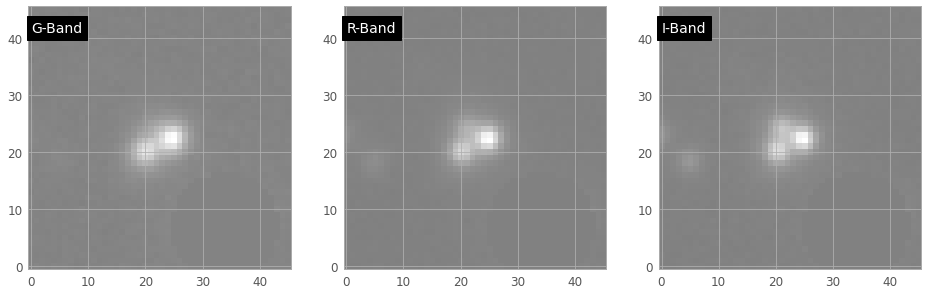

Computing the PSO ...
10
20
Max iteration reached! Stopping.
-2.344237694717021 reduced X^2 of best position
-7412.47959069522 logL
6324.0 effective number of data points
[{'theta_E': 1.1644622374726878, 'e1': -0.36640953581629343, 'e2': 0.10558557322681936, 'center_x': -0.5114752493973166, 'center_y': 0.49402590679699426}] lens result
[] source result
[{'amp': 1, 'R_sersic': 2.035358439891089, 'n_sersic': 2.0140467852267157, 'e1': 0.17006176309618473, 'e2': -0.06504005089638448, 'center_x': -0.3863807492802931, 'center_y': 0.431242923187432}] lens light result
[{'ra_image': array([-0.55278643,  0.57024851]), 'dec_image': array([-0.60698346, -0.04607931]), 'point_amp': array([1., 1.])}] point source result
{} special param result
1.2365050315856934 time used for  PSO


100%|███████████████████████████████████████████| 80/80 [00:43<00:00,  1.83it/s]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  20
Sampling iterations (in current run): 80
44.35584306716919 time taken for MCMC sampling
-1.5217284756813718 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.18536141387837846
reduced chi^2 of data  1 =  0.9757269305802266
reduced chi^2 of data  2 =  3.404097082585511


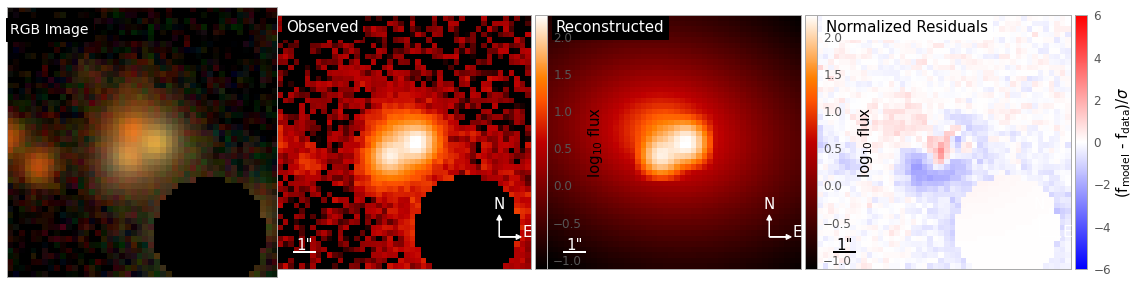

{'kwargs_lens': [{'theta_E': 1.2068778212009008, 'e1': -0.2848507838893147, 'e2': 0.1326722686066097, 'center_x': -0.5149807075247833, 'center_y': 0.48574200739762563}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 418.3749778256501, 'R_sersic': 2.0011289267543457, 'n_sersic': 2.0361663907568595, 'e1': 0.15769669196036407, 'e2': -0.0560375669507695, 'center_x': -0.3976424194078099, 'center_y': 0.3941008866113106}], 'kwargs_ps': [{'ra_image': array([-0.57976765,  0.58245778]), 'dec_image': array([-0.62755578, -0.04190443]), 'point_amp': array([5921.47428741, 7928.92279049])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =1.21
Actual: theta_E=0.77 +- 0.01


In [6]:
# coadd_id = 1146879846
# lens position
center_x=-0.56
center_y=0.38

# image positions
x_images = [-0.77,0.33]
y_images = [-0.92,-0.16]


# image amps:
image_amps_g = [1162.8, 1912.3]
image_amps_r = [2504.7, 4581.9]
image_amps_i = [3615.4, 6046.7]


# initial guesses for params
kwargs_lens_initial = {'theta_E': 1, 'e1': -0.05, 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 2, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}
# run model
model(coadd_id = 1146879846, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      image_amps_g=image_amps_g, image_amps_r=image_amps_r, image_amps_i=image_amps_i,
      mask_list= [{'mask_center_x': 3.03 , 'mask_center_y': -4.09, 'mask_radius':2.5}]
     )

print('Actual: theta_E=0.77 +- 0.01')



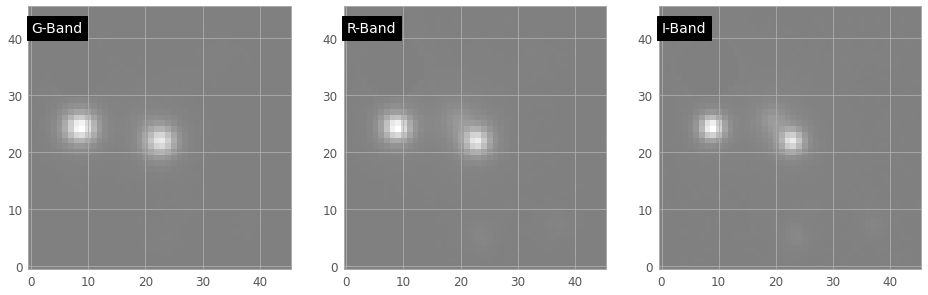

Computing the PSO ...
10
20
Max iteration reached! Stopping.
-10.314526181672072 reduced X^2 of best position
-32614.53178644709 logL
6324.0 effective number of data points
[{'theta_E': 2.0112693678011024, 'e1': -0.44668257598111094, 'e2': -0.18998237924525374, 'center_x': -0.5037513780226806, 'center_y': 0.46020256491197686}] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.710181038535212, 'n_sersic': 2.364371866842552, 'e1': -0.31621482884709506, 'e2': -0.11539478156849729, 'center_x': -0.48877191862319647, 'center_y': 0.4750123107839395}] lens light result
[{'ra_image': array([ 0.10110933, -3.67244688]), 'dec_image': array([-0.17782572,  0.4194375 ]), 'point_amp': array([1., 1.])}] point source result
{} special param result
1.7670929431915283 time used for  PSO


100%|███████████████████████████████████████████| 80/80 [00:48<00:00,  1.64it/s]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  20
Sampling iterations (in current run): 80
49.33259892463684 time taken for MCMC sampling
-6.219519428868542 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  2.274836749770568
reduced chi^2 of data  1 =  5.220617512003695
reduced chi^2 of data  2 =  11.163104024831362


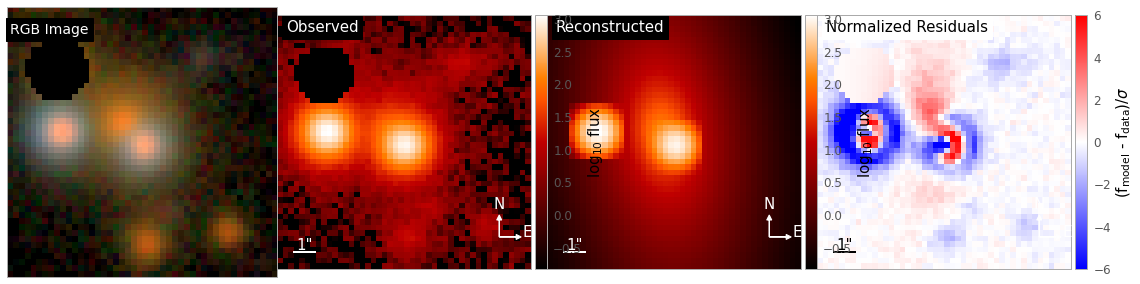

{'kwargs_lens': [{'theta_E': 1.9568665856443692, 'e1': -0.39192985144431136, 'e2': -0.19772957787351536, 'center_x': -0.523559425743015, 'center_y': 0.45012615550711566}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 962.8434664282538, 'R_sersic': 1.7422258253341876, 'n_sersic': 2.3508589157098316, 'e1': -0.3192110728644146, 'e2': -0.07380915941009622, 'center_x': -0.5379408675068084, 'center_y': 0.43921986778427335}], 'kwargs_ps': [{'ra_image': array([ 0.09900789, -3.63487285]), 'dec_image': array([-0.15066008,  0.47283747]), 'point_amp': array([22138.33337389, 33129.81242046])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =1.96
Actual theta_E: 1.97 +- 0.03


In [10]:
# coadd_id = 1532350418
# lens position
center_x=-0.5
center_y=0.5

# image positions
x_images = [-0.0,-3.7]
y_images = [-0.3,0.3]

# image amps:
image_amps_g = [16749.4, 20150.3]
image_amps_r = [21291.7, 23922.3]
image_amps_i = [28689, 31787.7]

# initial guesses for params
kwargs_lens_initial = {'theta_E': 2, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}


# run model
model(coadd_id = 1532350418, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      image_amps_g=image_amps_g, image_amps_r=image_amps_r, image_amps_i=image_amps_i,
      mask_list= [{'mask_center_x': -3.8 , 'mask_center_y': 3.2, 'mask_radius':1.4}]
     )
print('Actual theta_E: 1.97 +- 0.03')



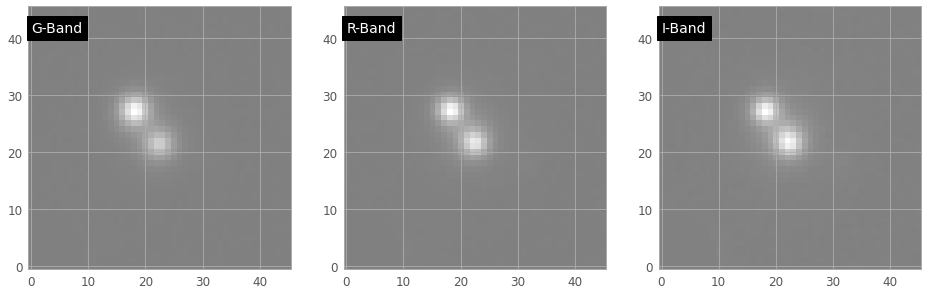

Computing the PSO ...
10
20
Max iteration reached! Stopping.
-4.083058537784958 reduced X^2 of best position
-12910.631096476038 logL
6324.0 effective number of data points
[{'theta_E': 0.9993859718931728, 'e1': 0.10849285435118688, 'e2': -0.09447531882322843, 'center_x': -0.24651413903786762, 'center_y': -0.17497236054219326}] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.7886159731529258, 'n_sersic': 1.7544107624595697, 'e1': 0.3624941632417975, 'e2': -0.008273499713577423, 'center_x': -0.10112108026263902, 'center_y': -0.026277481852479027}] lens light result
[{'ra_image': array([-1.09558479, -0.08611791]), 'dec_image': array([ 1.2622818 , -0.36389907]), 'point_amp': array([1., 1.])}] point source result
{} special param result
1.938244104385376 time used for  PSO


100%|███████████████████████████████████████████| 80/80 [00:44<00:00,  1.79it/s]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  20
Sampling iterations (in current run): 80
45.14417791366577 time taken for MCMC sampling
-2.1144536871043544 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.8149304001103382
reduced chi^2 of data  1 =  1.9111644081898007
reduced chi^2 of data  2 =  3.6172662530129247


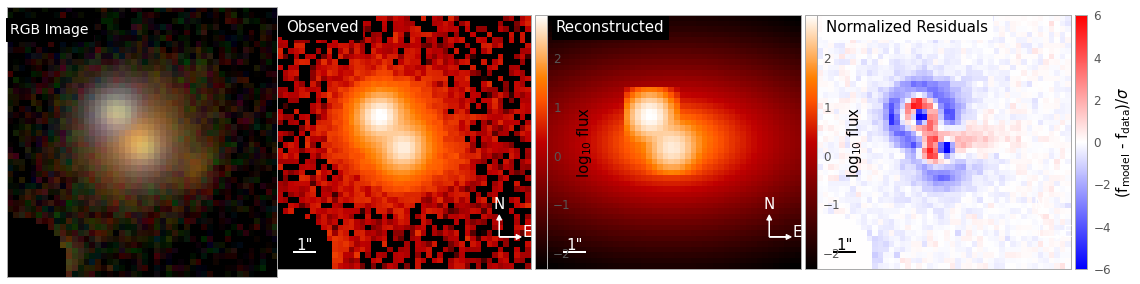

{'kwargs_lens': [{'theta_E': 0.9991732235204247, 'e1': 0.13955000662139255, 'e2': -0.11892686689849363, 'center_x': -0.2699013403765872, 'center_y': -0.1628495679793544}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 3114.1365892421145, 'R_sersic': 0.7869190318841164, 'n_sersic': 1.7816855581177662, 'e1': 0.3287759508211086, 'e2': 0.007457428010288725, 'center_x': -0.09726171953084402, 'center_y': -0.006592280344022287}], 'kwargs_ps': [{'ra_image': array([-1.1298885 , -0.07668637]), 'dec_image': array([ 1.25840507, -0.33357868]), 'point_amp': array([16940.58437452,  8459.57729745])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =1.0
Actual theta_E: 0.90 +- 0.02


In [9]:
# coadd_id = 1330959670
# lens position
center_x=-0.18
center_y=-0.08

# image positions
x_images = [-1.4,0.5]
y_images = [1.3,-0.8]

# image amps:
image_amps_g = [12749.7, 8672.2]
image_amps_r = [15258.5, 14319.3]
image_amps_i = [16652.0, 18111.6]


# initial guesses for params
kwargs_lens_initial = {'theta_E': 1, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}


# run model
model(coadd_id = 1330959670, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      image_amps_g=image_amps_g, image_amps_r=image_amps_r, image_amps_i=image_amps_i,
      mask_list= [{'mask_center_x':-5.8, 'mask_center_y':-5.8, 'mask_radius':2.5}]
     )
print('Actual theta_E: 0.90 +- 0.02')



Computing the PSO ...
10
20
Max iteration reached! Stopping.
-3.219245481369132 reduced X^2 of best position
-10179.254212089196 logL
6324.0 effective number of data points
[{'theta_E': 1.6315890663845691, 'e1': 0.11184879552829546, 'e2': 0.02918381480693602, 'center_x': -0.15182408949033363, 'center_y': -0.11086027290238563}] lens result
[] source result
[{'amp': 1, 'R_sersic': 2.9544790113573947, 'n_sersic': 3.8594012058682585, 'e1': -0.024891926163371776, 'e2': -0.04806181833692845, 'center_x': -0.10142908261130194, 'center_y': -0.02259719369833241}] lens light result
[{'ra_image': array([-2.24280255,  0.86907136]), 'dec_image': array([ 0.06171352, -0.04772244]), 'point_amp': array([1., 1.])}] point source result
{} special param result
2.6109039783477783 time used for  PSO


100%|███████████████████████████████████████████| 80/80 [00:55<00:00,  1.45it/s]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  20
Sampling iterations (in current run): 80
55.77961206436157 time taken for MCMC sampling
-0.9246549565961105 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.6187960513202501
reduced chi^2 of data  1 =  0.6865177608866565
reduced chi^2 of data  2 =  1.4686510575814253


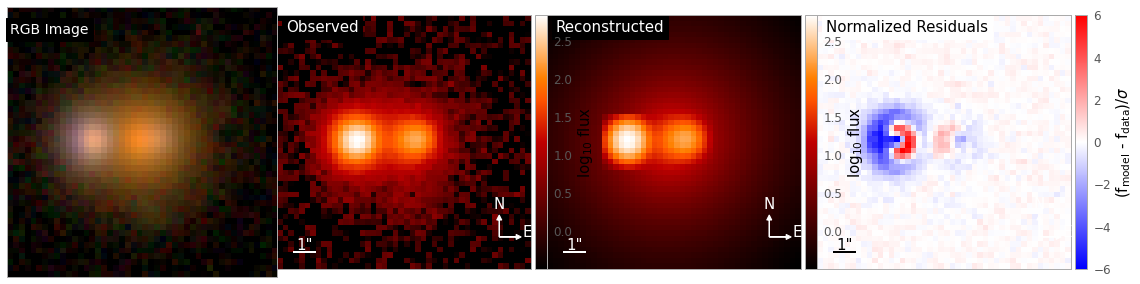

{'kwargs_lens': [{'theta_E': 1.4727027661340175, 'e1': 0.08595769108784351, 'e2': 0.12711280003880188, 'center_x': -0.31896332680965944, 'center_y': -0.14582449666768083}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 335.7201108092847, 'R_sersic': 2.9221147936438276, 'n_sersic': 3.572949638947151, 'e1': 0.0017342478923903296, 'e2': 0.022698297385052073, 'center_x': -0.13930517970070383, 'center_y': 0.06124080177176634}], 'kwargs_ps': [{'ra_image': array([-2.19013892,  0.56145805]), 'dec_image': array([0.07546877, 0.14003654]), 'point_amp': array([19407.6479129 ,  4902.21445016])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =1.47
Actual theta_E: 1.44 +- 0.02


In [12]:
# coadd_id = 1212441684
# lens position
center_x=-0.2
center_y=-0.1

# image positions
x_images = [-2.4,1.0]
y_images = [0.0,0.0]

# image amps:
image_amps_g = [10400.3, 3178.5]
image_amps_r = [12994.9, 7080.4]
image_amps_i = [18050.0, 11491.3]

# initial guesses for params
kwargs_lens_initial = {'theta_E': 1.5, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 3, 'n_sersic': 4, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

# run model
model(coadd_id = 1212441684, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      image_amps_g=image_amps_g, image_amps_r=image_amps_r, image_amps_i=image_amps_i,
      mask_list= None)
print('Actual theta_E: 1.44 +- 0.02')



Computing the PSO ...
10
20
Max iteration reached! Stopping.
-46.748084809258316 reduced X^2 of best position
-147817.4441668748 logL
6324.0 effective number of data points
[{'theta_E': 1.1627595279547691, 'e1': -0.4904145332921751, 'e2': -0.1628540690365181, 'center_x': 1.5651478114562567, 'center_y': 0.11966582049173108}] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.9559791272214122, 'n_sersic': 2.155841939805656, 'e1': 0.29699839434756403, 'e2': 0.2084270652366771, 'center_x': -1.7066306259648194, 'center_y': 0.17097242700724222}] lens light result
[{'ra_image': array([-0.93881754,  1.77503659]), 'dec_image': array([0.06844751, 0.13534911]), 'point_amp': array([1., 1.])}] point source result
{} special param result
1.3373677730560303 time used for  PSO


100%|███████████████████████████████████████████| 80/80 [00:34<00:00,  2.30it/s]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  20
Sampling iterations (in current run): 80
35.25609588623047 time taken for MCMC sampling
-26.91044784003652 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  12.234958375536833
reduced chi^2 of data  1 =  20.737357601876717
reduced chi^2 of data  2 =  47.759027542696025


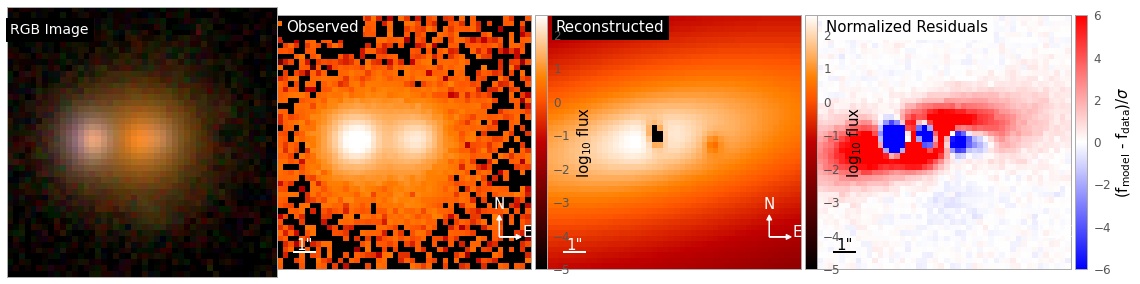

{'kwargs_lens': [{'theta_E': 1.3040510616419003, 'e1': -0.4629195639810558, 'e2': -0.13330622368402956, 'center_x': 1.6165142731399584, 'center_y': 0.13533447277577915}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 4689.851140005379, 'R_sersic': 1.0689618823470677, 'n_sersic': 1.7896314201309138, 'e1': 0.4855846885998814, 'e2': 0.20063271879424416, 'center_x': -1.3625276702354499, 'center_y': 0.10658974890872527}], 'kwargs_ps': [{'ra_image': array([-0.99428478,  1.72183382]), 'dec_image': array([0.22110226, 0.08150597]), 'point_amp': array([-15677.37530807,    -73.74177291])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =1.3
Actual theta_E: 1.24 +- 0.02


In [25]:
# coadd_id = 1025921566
# lens position
center_x=1.5
center_y=0.2

# image positions
x_images = [-0.3,2.0]
y_images = [-0.2,0.1]

# initial guesses for params
kwargs_lens_initial = {'theta_E': 1, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}


# run model
model(coadd_id = 1212441684, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      image_amps_g=image_amps_g, image_amps_r=image_amps_r, image_amps_i=image_amps_i,
      mask_list= None)
print('Actual theta_E: 1.24 +- 0.02')



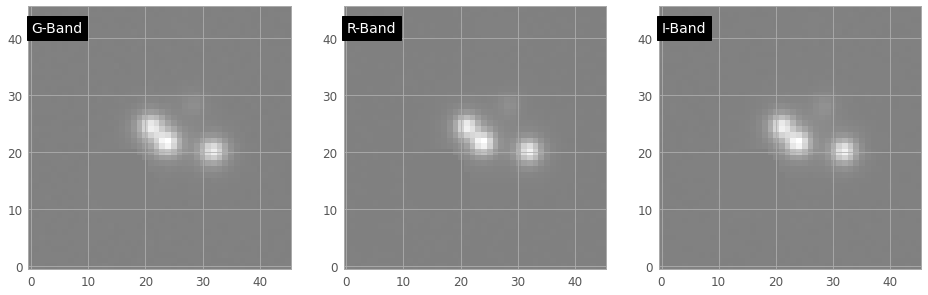

Computing the PSO ...
10
20
Max iteration reached! Stopping.
-59.42765639165154 reduced X^2 of best position
-187613.11122844392 logL
6314.0 effective number of data points
[{'theta_E': 1.47841562528298, 'e1': -0.31836890170991594, 'e2': 0.05412916816399568, 'center_x': 1.324224748832912, 'center_y': 0.9477507342226451}] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.9100968338178187, 'n_sersic': 3.082749742373279, 'e1': -0.345212259583294, 'e2': 0.1168138237445836, 'center_x': 1.344493324080971, 'center_y': 0.859486277743847}] lens light result
[{'ra_image': array([-0.25624057,  0.0073488 ,  1.46714866,  2.50585213]), 'dec_image': array([ 0.0950398 ,  0.00290886,  1.75682264, -0.43175506]), 'point_amp': array([1., 1., 1., 1.])}] point source result
{} special param result
1.7637989521026611 time used for  PSO


100%|███████████████████████████████████████████| 80/80 [01:15<00:00,  1.06it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  20
Sampling iterations (in current run): 80
76.76421809196472 time taken for MCMC sampling
-28.51081941436802 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  6.430272464670294
reduced chi^2 of data  1 =  33.81312544380671
reduced chi^2 of data  2 =  45.28906033462705


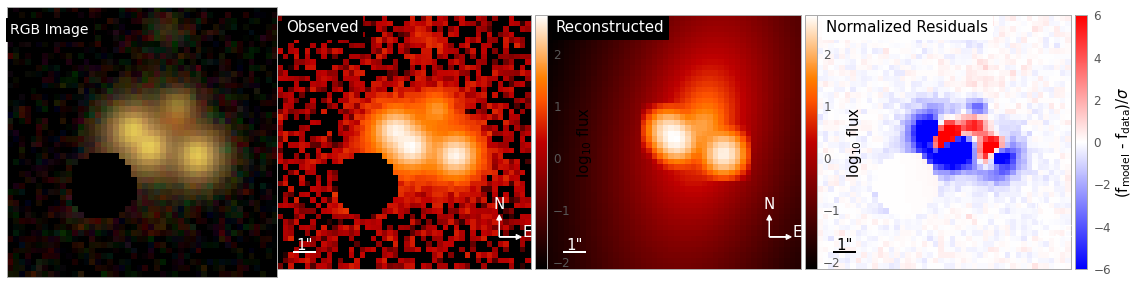

{'kwargs_lens': [{'theta_E': 1.3509543956919094, 'e1': -0.2206603668483884, 'e2': 0.42821501701969517, 'center_x': 1.1084592962917152, 'center_y': 0.7821662088988047}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 770.7352257266703, 'R_sersic': 0.8823131879302302, 'n_sersic': 2.853311259990579, 'e1': -0.2895289695086966, 'e2': 0.13027034790320408, 'center_x': 1.3715674215108857, 'center_y': 0.8454232443276156}], 'kwargs_ps': [{'ra_image': array([-0.29281053,  0.14136129,  1.30371332,  2.38538393]), 'dec_image': array([ 0.53632718,  0.07787107,  1.43611582, -0.54829689]), 'point_amp': array([11982.30789899, 15776.5370399 ,  -189.53428383, 16872.63234847])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =1.35
Actual theta_E: 1.17 +- 0.01


In [14]:
# coadd_id = 1112574265
# lens position
center_x=1.4
center_y=0.8

# image positions
x_images = [-0.6,0.1,1.4,2.4]
y_images = [0.4,-0.4,1.5,-0.7]

# image amps:
image_amps_g = [3257.9, 4466.0, 486.3, 2943.4]
image_amps_r = [7325.2, 9878.9, 1151.5, 6761.2]
image_amps_i = [8538.2, 11588.7, 1511.8, 7924.5]


# initial guesses for params
kwargs_lens_initial = {'theta_E': 1, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 3, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}



# run model
model(coadd_id = 1112574265, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      image_amps_g=image_amps_g, image_amps_r=image_amps_r, image_amps_i=image_amps_i,
      mask_list= [{'mask_center_x': -1.8 , 'mask_center_y': -2.0, 'mask_radius':1.5}]
     )

print('Actual theta_E: 1.17 +- 0.01')



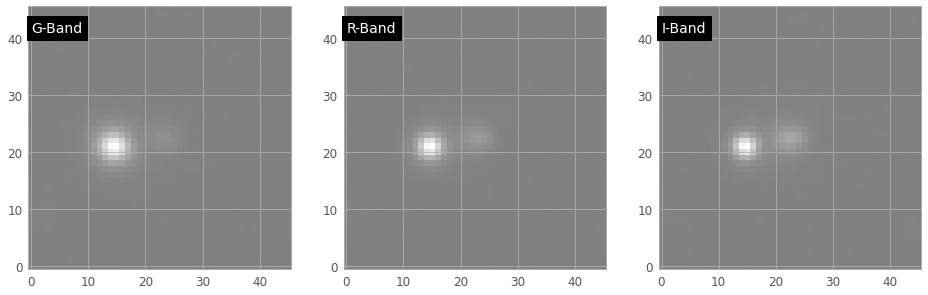

Computing the PSO ...
10
20
Max iteration reached! Stopping.
-1.044561560606874 reduced X^2 of best position
-3302.9036546389357 logL
6324.0 effective number of data points
[{'theta_E': 1.2742909120821528, 'e1': 0.07174367140643186, 'e2': 0.01148175462975109, 'center_x': -0.35490812039738157, 'center_y': -0.05696815480575755}] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.9913828803372402, 'n_sersic': 2.041893339014284, 'e1': -0.0067213111696886145, 'e2': -0.09820284672778826, 'center_x': -0.3246519053774737, 'center_y': -0.12720518500595268}] lens light result
[{'ra_image': array([-2.08862695,  0.34975846]), 'dec_image': array([-0.42064898,  0.05598421]), 'point_amp': array([1., 1.])}] point source result
{} special param result
1.6422009468078613 time used for  PSO


100%|███████████████████████████████████████████| 80/80 [00:46<00:00,  1.72it/s]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  20
Sampling iterations (in current run): 80
47.03451609611511 time taken for MCMC sampling
-0.9899174293098306 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.6111461956451063
reduced chi^2 of data  1 =  0.775219814009456
reduced chi^2 of data  2 =  1.5833862782749293


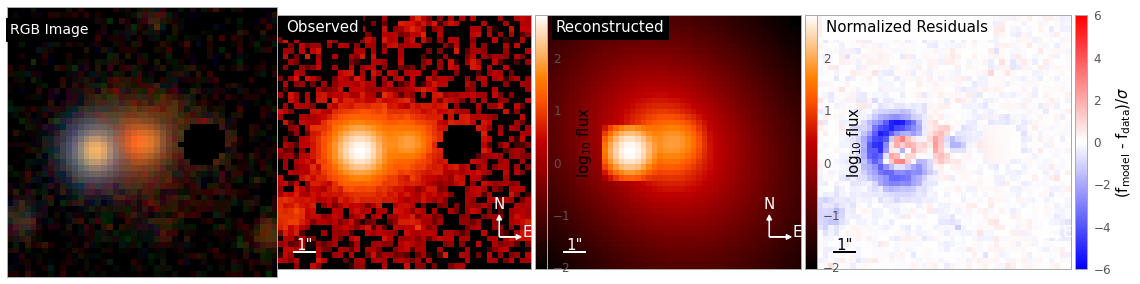

{'kwargs_lens': [{'theta_E': 1.2607259344287323, 'e1': 0.09622149555122285, 'e2': 0.004386151201086867, 'center_x': -0.3563038641396564, 'center_y': -0.05478009028780581}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 1033.505994838187, 'R_sersic': 1.003575041273879, 'n_sersic': 2.019682648055024, 'e1': -0.011085080485533406, 'e2': -0.09360657110273599, 'center_x': -0.3596022223812844, 'center_y': -0.09260226331774751}], 'kwargs_ps': [{'ra_image': array([-2.08919875,  0.30425607]), 'dec_image': array([-0.42061428,  0.0244424 ]), 'point_amp': array([20504.75179298,  3520.40555811])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =1.26
Actual theta_E: 1.22 +- 0.02


In [15]:
# 1596823754
# lens position
center_x=-0.3
center_y=-0.1

# image positions
x_images = [-2.3,0.5]
y_images = [-0.5,0.0]

# image amps
image_amps_g = [9173.5, 1264.5]
image_amps_r = [13449.9, 3516.6]
image_amps_i = [17272.0, 7347.4]

# initial guesses for params
kwargs_lens_initial = {'theta_E': 1, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

# run model
model(coadd_id = 1596823754, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      image_amps_g=image_amps_g, image_amps_r=image_amps_r, image_amps_i=image_amps_i,
      mask_list= [{'mask_center_x': 2.7 , 'mask_center_y': -0.1, 'mask_radius':1}])
print('Actual theta_E: 1.22 +- 0.02')



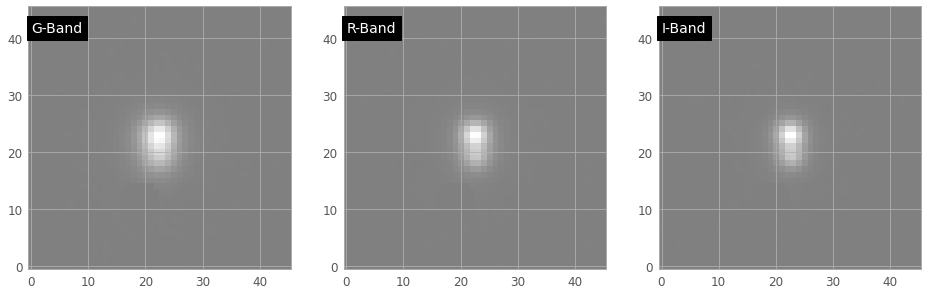

Computing the PSO ...
10
20
Max iteration reached! Stopping.
-3.6745402595070504 reduced X^2 of best position
-11618.896300561293 logL
6324.0 effective number of data points
[{'theta_E': 0.6986684491835219, 'e1': 0.21701627366838913, 'e2': 0.10123165375561845, 'center_x': -0.37292567708905805, 'center_y': -0.46845067708074095}] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.4794821095123632, 'n_sersic': 2.1997215370182026, 'e1': -0.12990743826945694, 'e2': -0.19116126842529607, 'center_x': -0.06436004008149299, 'center_y': -0.6229209001439386}] lens light result
[{'ra_image': array([0.01918615, 0.16520673]), 'dec_image': array([ 0.18496452, -1.05292739]), 'point_amp': array([1., 1.])}] point source result
{} special param result
1.5795598030090332 time used for  PSO


100%|███████████████████████████████████████████| 80/80 [00:43<00:00,  1.83it/s]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  20
Sampling iterations (in current run): 80
44.3326530456543 time taken for MCMC sampling
-2.609300582916746 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.6211621885093424
reduced chi^2 of data  1 =  2.573961286519951
reduced chi^2 of data  2 =  3.6327782737209438


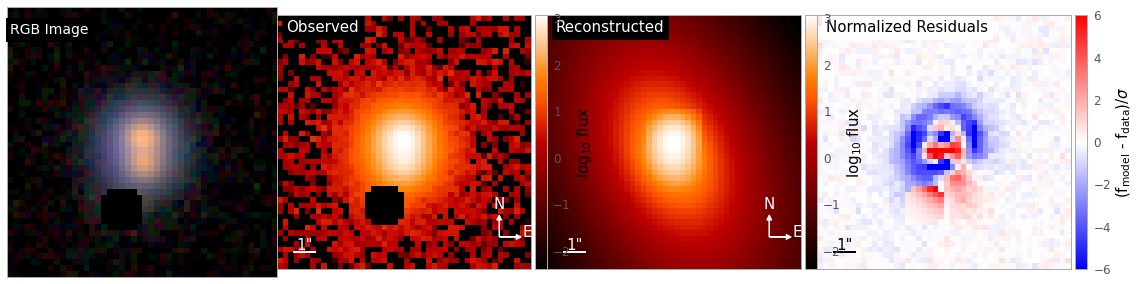

{'kwargs_lens': [{'theta_E': 0.7011919045365573, 'e1': 0.22031834130658123, 'e2': 0.08095630919586941, 'center_x': -0.4321949401571826, 'center_y': -0.46558084613888434}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 5546.635184763658, 'R_sersic': 0.5379747943641802, 'n_sersic': 2.215987899150275, 'e1': -0.17036271645110274, 'e2': -0.17837082575584962, 'center_x': -0.09384955823898619, 'center_y': -0.5769465201076576}], 'kwargs_ps': [{'ra_image': array([0.01029775, 0.18177435]), 'dec_image': array([ 0.18580383, -0.98146045]), 'point_amp': array([30640.88052629,  8309.91790015])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =0.7
Actual theta_E: 0.49 +- 0.01


In [23]:
# 1331771342
# lens position
center_x=-0.2
center_y=-0.6

# images
x_images = [-0.2,-0.2]
y_images = [0.1,-1.2]

# image amps
image_amps_g = [15085.5, 9339.1]
image_amps_r = [19260.6, 11343.2]
image_amps_i = [26034.6, 15140.8]

# initial guesses
kwargs_lens_initial = {'theta_E': 0.5, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 0.5, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

# run model
model(coadd_id = 1331771342, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      image_amps_g=image_amps_g, image_amps_r=image_amps_r, image_amps_i=image_amps_i,
      mask_list= [{'mask_center_x': -0.9 , 'mask_center_y': -3.0, 'mask_radius':1}])
print('Actual theta_E: 0.49 +- 0.01')

In [ ]:
# 1406996169
# lens position
center_x=-0.1
center_y=-0.3

# image positions
x_images = [-3.9,-0.8,0.3]
y_images = [3.1,-3.2,0.3]

# image amps
image_amps_g = []
image_amps_r = []
image_amps_i = []

# initial guesses
kwargs_lens_initial = {'theta_E': 1.5, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic':2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

# run model
model(coadd_id = 1406996169, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      mask_list= [{'mask_center_x': -3.7 , 'mask_center_y': 0.2, 'mask_radius':1.7}])
print('Actual theta_E: n/a')



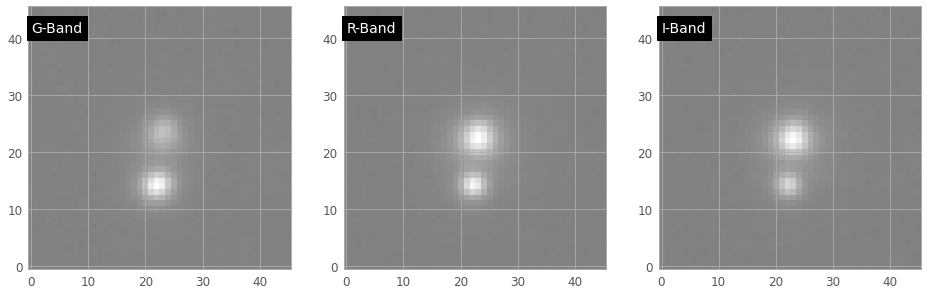

Computing the PSO ...
10
20
Max iteration reached! Stopping.
-1.3586873687663625 reduced X^2 of best position
-4296.169460039238 logL
6324.0 effective number of data points
[{'theta_E': 1.2883402816336764, 'e1': -0.03514662219271878, 'e2': 0.12576011893993316, 'center_x': -0.174149950482621, 'center_y': -0.3383523003436922}] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.0475849836628026, 'n_sersic': 2.3613057969434323, 'e1': 0.14463800647179362, 'e2': -0.0057149615028498964, 'center_x': 0.0826613385384184, 'center_y': -0.18145810322091183}] lens light result
[{'ra_image': array([-0.06238754,  0.06147679]), 'dec_image': array([-2.09346537,  0.37046653]), 'point_amp': array([1., 1.])}] point source result
{} special param result
1.486562728881836 time used for  PSO


100%|███████████████████████████████████████████| 80/80 [00:48<00:00,  1.67it/s]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  20
Sampling iterations (in current run): 80
48.614367961883545 time taken for MCMC sampling
-0.4177635722398845 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.22623757369158126
reduced chi^2 of data  1 =  0.33614260127295204
reduced chi^2 of data  2 =  0.6909105417551199


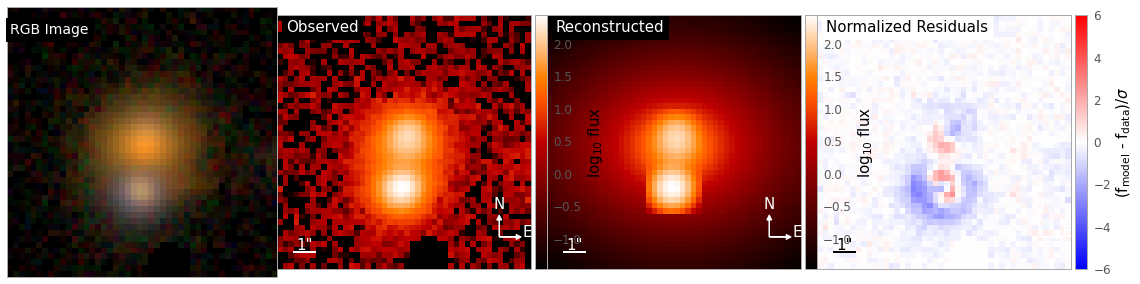

{'kwargs_lens': [{'theta_E': 1.333309083459635, 'e1': -0.030127338780762826, 'e2': 0.13863321601329243, 'center_x': -0.1692387130562395, 'center_y': -0.35790735332373463}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 1764.3198513388543, 'R_sersic': 1.0286810365921393, 'n_sersic': 2.3087010093936375, 'e1': 0.14720388241855184, 'e2': 0.002592648952061386, 'center_x': 0.09983807773767411, 'center_y': -0.17266971852802676}], 'kwargs_ps': [{'ra_image': array([-0.08047057,  0.10393168]), 'dec_image': array([-2.16553324,  0.36976397]), 'point_amp': array([7220.99383889, 2110.06268548])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =1.33
Actual theta_E: 1.30 +- 0.02


In [19]:
# 1456100148
# lens position
center_x=-0.1
center_y=-0.3

# image positions
x_images = [-0.3,-0.0]
y_images = [-2.4,0.9]

# image amps
image_amps_g = [5167.5, 3355.0]
image_amps_r = [6384.3, 9323.4]
image_amps_i = [7975.6, 14633.2]

# initial guesses for params
kwargs_lens_initial = {'theta_E': 1.5, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

# run model
model(coadd_id = 1456100148, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      image_amps_g=image_amps_g, image_amps_r=image_amps_r, image_amps_i=image_amps_i,
      mask_list= [{'mask_center_x': 1.2 , 'mask_center_y': -5.5, 'mask_radius':1}])
print('Actual theta_E: 1.30 +- 0.02')

